In [1]:
from weatherbenchX import aggregation
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import categorical
from weatherbenchX.metrics import wrappers
from weatherbenchX.weighting import GridAreaWeighting

In [ ]:
import numpy as np
import xarray as xr
from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
# work_dir = Path("/Project/WB2BinaryForecast")
work_dir = Path.cwd()

# Load preprocessed data

This notebook is a part of code to reproduce the analysis of the manuscript "The extension of the WeatherBench 2 to binary hydroclimatic forecasts" (https://egusphere.copernicus.org/preprints/2025/egusphere-2025-3/) that has been submitted to the Geoscientific Model Development.

The preprocessed data below are archived on Zenodo at https://zenodo.org/records/14691031 and https://zenodo.org/records/15066828 and at https://zenodo.org/records/15066898. You can download these preprocessed data and follow the procedures below. You can also generate these preprocessed data following the code archived on Zenodo at https://doi.org/10.5281/zenodo.15067282.

Download the following files from the Zenodo repositories above:
- Thresholds.tar.gz
- Forecasts_tx24h_150_2020_hres_ens.tar.gz
- Forecasts_tp24h_150_2020_hres_ens.tar.gz
- Forecasts_tx24h_150_2020.tar.gz
- Forecasts_tp24h_150_2020.tar.gz

Unzip these files:
```bash
tar -zxvf Thresholds.tar.gz
tar -zxvf Forecasts_tx24h_150_2020_hres_ens.tar.gz
tar -zxvf Forecasts_tp24h_150_2020_hres_ens.tar.gz
tar -zxvf Forecasts_tx24h_150_2020.tar.gz
tar -zxvf Forecasts_tp24h_150_2020.tar.gz
```

## Load quantile thresholds

In [4]:
tx24h_era5_threshold = xr.open_dataset(
    work_dir / "Threshold_tx24h_150_2020_era5.nc")["2m_temperature"].load()
tx24h_hres0_threshold = xr.open_dataset(
    work_dir / "Threshold_tx24h_150_2020_hres0.nc")["2m_temperature"].load()
tp24h_era5_threshold = xr.open_dataset(
    work_dir / "Threshold_tp24h_150_2020_era5.nc")["total_precipitation_24hr"].load()

In [5]:
tp24h_era5_threshold

<xarray.DataArray 'total_precipitation_24hr' (quantile: 9, longitude: 240,
                                              latitude: 121)> Size: 1MB
array([[[0.00031968, 0.00023233, 0.00018868, ..., 0.00110248,
         0.00105443, 0.00110291],
        [0.00032307, 0.00023081, 0.00018698, ..., 0.0010987 ,
         0.00102627, 0.00110094],
        [0.00032303, 0.00022501, 0.00018772, ..., 0.00108141,
         0.00102935, 0.00110815],
        ...,
        [0.00032204, 0.0002398 , 0.00018959, ..., 0.00110758,
         0.00102445, 0.00109458],
        [0.00032043, 0.00023159, 0.000189  , ..., 0.00107088,
         0.00104041, 0.0010974 ],
        [0.0003179 , 0.00023433, 0.00018847, ..., 0.00108509,
         0.0010677 , 0.00110056]],

       [[0.00043494, 0.00036091, 0.00027239, ..., 0.00143941,
         0.00149755, 0.00146319],
        [0.0004344 , 0.00035176, 0.00027295, ..., 0.00148088,
         0.00152076, 0.0014578 ],
        [0.00043369, 0.00034607, 0.0002758 , ..., 0.00148857,
         0.00155281, 0.0014556 ],
...
        [0.00133265, 0.00143429, 0.00119447, ..., 0.00569249,
         0.00524832, 0.00485806],
        [0.00133649, 0.00143549, 0.0011872 , ..., 0.00572483,
         0.00519512, 0.00485711],
        [0.0013436 , 0.00143575, 0.00118151, ..., 0.00585162,
         0.00515334, 0.00487259]],

       [[0.00198994, 0.00193295, 0.00139853, ..., 0.00685882,
         0.00822698, 0.00767184],
        [0.0019997 , 0.00192544, 0.00136566, ..., 0.00701881,
         0.00827293, 0.00763758],
        [0.00201158, 0.00191704, 0.00133116, ..., 0.00706686,
         0.00828089, 0.00760092],
        ...,
        [0.00196915, 0.00194407, 0.00148535, ..., 0.00629509,
         0.00791044, 0.00776459],
        [0.00197541, 0.00193915, 0.00145616, ..., 0.00636168,
         0.00791521, 0.00773682],
        [0.00198221, 0.00193535, 0.00142645, ..., 0.00658411,
         0.00812976, 0.00770391]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 968B -90.0 -88.5 -87.0 ... 87.0 88.5 90.0
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * quantile   (quantile) float64 72B 0.8 0.85 0.9 0.93 0.95 0.96 0.97 0.98 0.99

## Load ground truth data

In [6]:
tp24h_era5 = xr.open_dataset(work_dir / "Data_tp24h_150_2020_era5.nc")
tx24h_era5 = xr.open_dataset(work_dir / "Data_tx24h_150_2020_era5.nc")
tx24h_hres0 = xr.open_dataset(work_dir / "Data_tx24h_150_2020_hres0.nc")

## Load continuous forecasts resampled from the WeatherBench 2

- For models except HRES ENS, resampled continuous forecasts are stored in one netcdf file for lead times from 1 to 10 days.
- For HRES ENS, resampled continuous forecasts are stored in seperate netcdf file for each lead time due to the storage limitation.

In [7]:
tp24h_fcst = xr.open_dataset(work_dir / "Forecasts_tp24h_150_2020.nc")
tx24h_fcst = xr.open_dataset(work_dir / "Forecasts_tx24h_150_2020.nc")

In [8]:
tp24h_fcst

<xarray.Dataset> Size: 2GB
Dimensions:         (latitude: 121, longitude: 240, time: 366, lead_time: 10)
Coordinates:
  * latitude        (latitude) float64 968B -90.0 -88.5 -87.0 ... 87.0 88.5 90.0
  * longitude       (longitude) float64 2kB 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * time            (time) datetime64[ns] 3kB 2020-01-02 ... 2021-01-01
  * lead_time       (lead_time) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    hres            (lead_time, time, longitude, latitude) float32 425MB ...
    hres_ens_mean   (lead_time, time, longitude, latitude) float32 425MB ...
    graphcast       (lead_time, time, longitude, latitude) float32 425MB ...
    graphcast-oper  (lead_time, time, longitude, latitude) float32 425MB ...
    fuxi            (lead_time, time, longitude, latitude) float32 425MB ...

In [9]:
model_list_tp = ["hres", "hres_ens", "graphcast", "fuxi"]
model_list_tx = ["hres", "pangu", "graphcast", "fuxi"]

model_list_dict = {"tp": model_list_tp, "tx": model_list_tx}

In [10]:
lead_time = 5
forecasts_path = work_dir / f"Forecasts_tx24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
xr.open_dataset(forecasts_path)

<xarray.Dataset> Size: 4GB
Dimensions:         (number: 50, time: 723, longitude: 240, latitude: 121)
Coordinates:
  * latitude        (latitude) float64 968B -90.0 -88.5 -87.0 ... 87.0 88.5 90.0
  * longitude       (longitude) float64 2kB 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * number          (number) int64 400B 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * time            (time) datetime64[ns] 6kB 2020-01-06 ... 2021-01-01
    lead_time       int64 8B ...
Data variables:
    2m_temperature  (number, time, longitude, latitude) float32 4GB ...

- SEDS, SEDI, H, F, ACC, SR, HSS, ORSS, EDS, EDI, GSS, PSS, CSI, TNR
- ROCSS 定义时要传给threshold_probability_dim
- REV 定义时要传给cost_lost_ratio，threshold_probability_dim
- BS 定义时要传给reduce_dims，同时在aggregator的定义中不需要传递reduce_dims

集合预报在定义WrappedMetric时要传给ensemble_dim

aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)

metrics = wrapped_metrics(continuous2binary_tp_era5)

aggregation.compute_metric_values_for_single_chunk(
    metrics,
    aggregator,
    prediction_data_loader._ds,
    target_data_loader._ds
)

# Define global wrappers

In [11]:
lead_time = 5 # days

In [ ]:
continuous2binary_tp_era5 = wrappers.ContinuousToBinary(
            which='both',
            threshold_value=tp24h_era5_threshold,   # Raw values are in m
            threshold_dim='quantile'
        )

continuous2binary_tx_era5 = wrappers.ContinuousToBinary(
            which='both',
            threshold_value=tx24h_era5_threshold,   # Raw values are in m
            threshold_dim='quantile'
        )
continuous2binary_tx_hres0 = wrappers.ContinuousToBinary(
            which='both',
            threshold_value=tx24h_hres0_threshold,   # Raw values are in m
            threshold_dim='quantile'
        )

ensmble2probabilistic = wrappers.EnsembleToProbabilistic(
            which='predictions', ensemble_dim='number'
        )

# Calculate the SEDS, SEDI, H, F, ACC, SR, HSS, ORSS, EDS, EDI, GSS, PSS, CSI, TNR

As the metrics below need the predefined probability threshold to convert the probabilistic forecasts to deterministic forecasts, they are calculated only for deterministic forecasts, i.e., HRES, Pangu-Weather, GraphCast and FuXi.
- SEDS, 
- SEDI, 
- H, 
- F, 
- ACC, 
- SR, 
- HSS, 
- ORSS, 
- EDS, 
- EDI, 
- GSS, 
- PSS, 
- CSI, 
- TNR

In [13]:
def wrapped_metrics(continuous2binary):
    wrapped_SEDS = wrappers.WrappedMetric(
        metric=categorical.SEDS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_SEDI = wrappers.WrappedMetric(
        metric=categorical.SEDI(),
        transforms=[
            continuous2binary,
        ],
    )

    wrapped_Recall = wrappers.WrappedMetric(
        metric=categorical.Recall(),
        transforms=[
            continuous2binary,
        ],
    )

    wrapped_F = wrappers.WrappedMetric(
        metric=categorical.F(),
        transforms=[
            continuous2binary,
        ],
    )

    wrapped_Accuracy = wrappers.WrappedMetric(
        metric=categorical.Accuracy(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_Precision = wrappers.WrappedMetric(
        metric=categorical.Precision(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_HSS = wrappers.WrappedMetric(
        metric=categorical.HSS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_ORSS = wrappers.WrappedMetric(
        metric=categorical.ORSS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_EDS = wrappers.WrappedMetric(
        metric=categorical.EDS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_EDI = wrappers.WrappedMetric(
        metric=categorical.EDI(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_GSS = wrappers.WrappedMetric(
        metric=categorical.GSS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_PSS = wrappers.WrappedMetric(
        metric=categorical.PSS(),
        transforms=[
            continuous2binary,
        ],
    )
    wrapped_CSI = wrappers.WrappedMetric(
        metric=categorical.CSI(),
        transforms=[
            continuous2binary,
        ],
    )

    wrapped_TNR = wrappers.WrappedMetric(
        metric=categorical.Specificity(),
        transforms=[
            continuous2binary,
        ],
    )
    return {"SEDS": wrapped_SEDS, "SEDI": wrapped_SEDI, 
            "H": wrapped_Recall, "F": wrapped_F, 
            "ACC": wrapped_Accuracy, "SR": wrapped_Precision, 
            "HSS": wrapped_HSS, "ORSS": wrapped_ORSS, 
            "EDS": wrapped_EDS, "EDI": wrapped_EDI, 
            "GSS": wrapped_GSS, "PSS": wrapped_PSS, 
            "CSI": wrapped_CSI, "TNR": wrapped_TNR}

## TP24h

In [14]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)

metrics = wrapped_metrics(continuous2binary_tp_era5)
results = []
for model_name in ["hres", "graphcast", "fuxi"]:
    threshold = tp24h_era5_threshold
    prediction_ds = xr.Dataset({
        "total_precipitation_24hr": tp24h_fcst[model_name]}
        ).sel(lead_time=lead_time).dropna(dim="time")
    target_ds = tp24h_era5.dropna(dim="time")

    time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
    prediction_ds = prediction_ds.sel(time=time_range)
    target_ds = target_ds.sel(time=time_range)

    target_data_loader = xarray_loaders.TargetsFromXarray(
        ds=target_ds,)
    prediction_data_loader = xarray_loaders.PredictionsFromXarray(
        ds=prediction_ds,)

    model_results = aggregation.compute_metric_values_for_single_chunk(
        metrics,
        aggregator,
        prediction_data_loader._ds,
        target_data_loader._ds
    )
    results.append(model_results)
results = xr.concat(results, dim="model_name")
results["model_name"] = ["hres", "graphcast", "fuxi"]

In [15]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_table_tp24h.nc")

## TX24h

In [16]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)
metrics = wrapped_metrics(continuous2binary_tp_era5)
results = []

for model_name in ["hres", "pangu", "graphcast", "fuxi"]:
    if model_name in ["hres", "hres_ens"]:
        threshold = tx24h_hres0_threshold
        target_ds = tx24h_hres0.dropna(dim="time")
        metrics = wrapped_metrics(continuous2binary_tx_hres0)
    else:
        threshold = tx24h_era5_threshold
        target_ds = tx24h_era5.dropna(dim="time")
        metrics = wrapped_metrics(continuous2binary_tx_era5)

    prediction_ds = xr.Dataset({
        "2m_temperature": tx24h_fcst[model_name]}
        ).sel(lead_time=lead_time).dropna(dim="time")
    
    time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
    prediction_ds = prediction_ds.sel(time=time_range)
    target_ds = target_ds.sel(time=time_range)

    target_data_loader = xarray_loaders.TargetsFromXarray(
        ds=target_ds,)
    prediction_data_loader = xarray_loaders.PredictionsFromXarray(
        ds=prediction_ds,)

    model_results = aggregation.compute_metric_values_for_single_chunk(
        metrics,
        aggregator,
        prediction_data_loader._ds,
        target_data_loader._ds
    )
    results.append(model_results)
results = xr.concat(results, dim="model_name")
results["model_name"] = ["hres", "pangu", "graphcast", "fuxi"]

In [17]:
results

<xarray.Dataset> Size: 2kB
Dimensions:              (model_name: 4, quantile: 9)
Coordinates:
    lead_time            int64 8B 5
  * quantile             (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * model_name           (model_name) <U9 144B 'hres' 'pangu' 'graphcast' 'fuxi'
Data variables: (12/14)
    SEDS.2m_temperature  (model_name, quantile) float32 144B 0.7564 ... 0.6649
    SEDI.2m_temperature  (model_name, quantile) float32 144B 0.8739 ... 0.6825
    H.2m_temperature     (model_name, quantile) float32 144B 0.7578 ... 0.3358
    F.2m_temperature     (model_name, quantile) float32 144B 0.03777 ... 0.00...
    ACC.2m_temperature   (model_name, quantile) float32 144B 0.9209 ... 0.9879
    SR.2m_temperature    (model_name, quantile) float32 144B 0.8355 ... 0.4624
    ...                   ...
    EDS.2m_temperature   (model_name, quantile) float32 144B 0.7044 ... 0.6074
    EDI.2m_temperature   (model_name, quantile) float32 144B 0.8439 ... 0.6636
    GSS.2m_temperature   (model_name, quantile) float32 144B 0.5948 ... 0.237
    PSS.2m_temperature   (model_name, quantile) float32 144B 0.72 ... 0.3313
    CSI.2m_temperature   (model_name, quantile) float32 144B 0.6594 ... 0.2415
    TNR.2m_temperature   (model_name, quantile) float32 144B 0.9622 ... 0.9955

In [18]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_table_tx24h.nc")

# Calculate the Receiver operating characteristic skill score (ROCSS)

The parameter (threshold_probability_dim) is necessary when the class (categorical.ROCSS) is instanced

In [19]:
probabilistic2binay = wrappers.ContinuousToBinary(
            which='predictions',
            threshold_value=np.arange(0, 1.011, 0.01),
            threshold_dim='threshold_probability'
        )

# For deterministic forecasts
def wrapped_roc_de(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.ROCSS(
            threshold_probability_dim='threshold_probability'
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
            probabilistic2binay
        ],
    )
# For ensemble forecasts
def wrapped_roc_en(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.ROCSS(
            threshold_probability_dim='threshold_probability'
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
            ensmble2probabilistic,
            probabilistic2binay
        ],
    )

In [20]:
import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client

with dask.config.set({"distributed.scheduler.worker-saturation": 1.0}):
    # client = Client(n_workers=6, threads_per_worker=3, memory_limit='10GB',
    client = Client(n_workers=4, threads_per_worker=3, memory_limit='15GB',
                   # local_directory="/data/tmp"
                   )

## TP24h

In [ ]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)
results = []
for model_name in tqdm(model_list_tp):
    model_results =[]
    for quantile in tqdm(tp24h_era5_threshold["quantile"].data, leave=False):
        threshold = tp24h_era5_threshold.sel(quantile=[quantile]).chunk(dict(longitude=-1, latitude=11))
        
        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tp24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"ROCSS": wrapped_roc_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "total_precipitation_24hr": tp24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"ROCSS": wrapped_roc_de(threshold)}
        
        target_ds = tp24h_era5.dropna(dim="time")

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)
 
        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds.chunk(dict(longitude=-1, latitude=11)),
            target_data_loader._ds.chunk(dict(longitude=-1, latitude=11))
        )
        model_results.append(quantile_results)
    #     break
    # break
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tp


In [24]:
results

<xarray.Dataset> Size: 368B
Dimensions:                         (model_name: 4, quantile: 9)
Coordinates:
    lead_time                       int64 8B 5
  * quantile                        (quantile) float64 72B 0.8 0.85 ... 0.99
  * model_name                      (model_name) <U9 144B 'hres' ... 'fuxi'
Data variables:
    ROCSS.total_precipitation_24hr  (model_name, quantile) float32 144B 0.527...

In [25]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_rocss_tp24h.nc")

## TX24h

In [ ]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)

results = []
for model_name in tqdm(model_list_tx):
    model_results = []
    for quantile in tqdm(tx24h_era5_threshold["quantile"].data, leave=False):

        if model_name in ["hres", "hres_ens"]:
            threshold = tx24h_hres0_threshold.sel(quantile=[quantile]).chunk(dict(latitude=11))
            target_ds = tx24h_hres0.dropna(dim="time")

        else:
            threshold = tx24h_era5_threshold.sel(quantile=[quantile]).chunk(dict(latitude=11))
            target_ds = tx24h_era5.dropna(dim="time")

        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tx24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"ROCSS": wrapped_roc_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "2m_temperature": tx24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"ROCSS": wrapped_roc_de(threshold)}

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)

        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds.chunk(dict(latitude=11)),
            target_data_loader._ds.chunk(dict(latitude=11))
        )
        model_results.append(quantile_results)
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tx

In [27]:
results

<xarray.Dataset> Size: 368B
Dimensions:               (model_name: 4, quantile: 9)
Coordinates:
    lead_time             int64 8B 5
  * quantile              (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * model_name            (model_name) <U9 144B 'hres' 'pangu' ... 'fuxi'
Data variables:
    ROCSS.2m_temperature  (model_name, quantile) float32 144B 0.72 ... 0.3313

In [28]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_rocss_tx24h.nc")

# Calculate the relative economic value (REV)

The parameters (cost_lost_ratio, threshold_probability_dim) are necessary when the class (categorical.ROCSS) is instanced

In [29]:
probabilistic2binay_rev = wrappers.ContinuousToBinary(
            which='predictions',
            threshold_value=np.arange(0, 50+2) / (50+1), # Weibull's position
            threshold_dim='threshold_probability'
        )

def wrapped_rev_de(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.PREV(
            cost_loss_ratios=[0.2],
            threshold_probability_dim='threshold_probability'
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
            probabilistic2binay_rev
        ],
    )
def wrapped_rev_en(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.PREV(
            cost_loss_ratios=[0.2],
            threshold_probability_dim='threshold_probability'
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
            ensmble2probabilistic,
            probabilistic2binay_rev
        ],
    )

## TP24h

In [30]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)

results = []
for model_name in tqdm(model_list_tp):
    model_results = []
    for quantile in tqdm(tp24h_era5_threshold["quantile"].data, leave=False):
        threshold = tp24h_era5_threshold.sel(quantile=[quantile]).chunk(dict(latitude=11))
        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tp24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"REV": wrapped_rev_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "total_precipitation_24hr": tp24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"REV": wrapped_rev_de(threshold)}
        
        target_ds = tp24h_era5.dropna(dim="time")

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)

        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds.chunk(dict(latitude=11)),
            target_data_loader._ds.chunk(dict(latitude=11))
        )
        model_results.append(quantile_results)
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tp

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
results

<xarray.Dataset> Size: 520B
Dimensions:                       (model_name: 4, quantile: 9,
                                   cost_loss_ratios: 1)
Coordinates:
    lead_time                     int64 8B 5
  * quantile                      (quantile) float64 72B 0.8 0.85 ... 0.98 0.99
  * cost_loss_ratios              (cost_loss_ratios) float64 8B 0.2
  * model_name                    (model_name) <U9 144B 'hres' ... 'fuxi'
Data variables:
    REV.total_precipitation_24hr  (model_name, quantile, cost_loss_ratios) float64 288B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>

In [32]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_rev_tp24h.nc")

/home/bennett/anaconda3/envs/map/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 282.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## TX24h

In [33]:
aggregator = aggregation.Aggregator(
  reduce_dims=['latitude', 'longitude', 'valid_time'],
  weigh_by=[GridAreaWeighting()]
)

results = []
for model_name in tqdm(model_list_tx):
    model_results = []
    for quantile in tqdm(tx24h_era5_threshold["quantile"].data, leave=False):

        if model_name in ["hres", "hres_ens"]:
            threshold = tx24h_hres0_threshold.sel(quantile=[quantile]).chunk(dict(latitude=11))
            target_ds = tx24h_hres0.dropna(dim="time")

        else:
            threshold = tx24h_era5_threshold.sel(quantile=[quantile]).chunk(dict(latitude=11))
            target_ds = tx24h_era5.dropna(dim="time")

        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tx24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"REV": wrapped_rev_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "2m_temperature": tx24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"REV": wrapped_rev_de(threshold)}

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)

        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds.chunk(dict(latitude=11)),
            target_data_loader._ds.chunk(dict(latitude=11))
        )
        
        model_results.append(quantile_results)
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tx

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [34]:
results

<xarray.Dataset> Size: 520B
Dimensions:             (model_name: 4, quantile: 9, cost_loss_ratios: 1)
Coordinates:
    lead_time           int64 8B 5
  * quantile            (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * cost_loss_ratios    (cost_loss_ratios) float64 8B 0.2
  * model_name          (model_name) <U9 144B 'hres' 'pangu' 'graphcast' 'fuxi'
Data variables:
    REV.2m_temperature  (model_name, quantile, cost_loss_ratios) float64 288B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>

In [35]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_rev_tx24h.nc")

/home/bennett/anaconda3/envs/map/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 283.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [36]:
xr.open_dataset(work_dir/ "Metrics_rev_tx24h.nc").load()

<xarray.Dataset> Size: 376B
Dimensions:             (model_name: 4, quantile: 9, cost_loss_ratios: 1)
Coordinates:
    lead_time           int64 8B 5
  * quantile            (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * cost_loss_ratios    (cost_loss_ratios) float64 8B 0.2
  * model_name          (model_name) <U9 144B 'hres' 'pangu' 'graphcast' 'fuxi'
Data variables:
    REV.2m_temperature  (model_name, quantile, cost_loss_ratios) float32 144B ...

# Calculate the Brier Score (BS)

The parameter (reduce_dims) is necessary when the class (categorical.ROCSS) is instanced.
In the meantime, the parameter (reduce_dims) is expected to be null when the clsss (aggregation.Aggregator) is instanced.

In [37]:

def wrapped_bs_de(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.BrierScore(
            reduce_dims=['latitude', 'longitude', 'valid_time']
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
        ],
    )
def wrapped_bs_en(threshold, ):
    return wrappers.WrappedMetric(
        metric=categorical.BrierScore(
            reduce_dims=['latitude', 'longitude', 'valid_time']
            ),
        transforms=[
            wrappers.ContinuousToBinary(
            which='both',
            threshold_value=threshold,   # Raw values are in m
            threshold_dim='quantile'
            ),
            ensmble2probabilistic,
        ],
    )

## TP24h

In [38]:
aggregator = aggregation.Aggregator(
  reduce_dims=[],
  weigh_by=[GridAreaWeighting()]
)

results = []
for model_name in tqdm(model_list_tp):

    model_results = []
    for quantile in tqdm(tp24h_era5_threshold["quantile"].data, leave=False):
        threshold = tp24h_era5_threshold.sel(quantile=[quantile])
        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tp24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"BS": wrapped_bs_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "total_precipitation_24hr": tp24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"BS": wrapped_bs_de(threshold)}
        
        target_ds = tp24h_era5.dropna(dim="time")

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)

        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds,
            target_data_loader._ds
        )
        model_results.append(quantile_results)
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tp

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [39]:
results

<xarray.Dataset> Size: 368B
Dimensions:                      (model_name: 4, quantile: 9)
Coordinates:
    lead_time                    int64 8B 5
  * quantile                     (quantile) float64 72B 0.8 0.85 ... 0.98 0.99
  * model_name                   (model_name) <U9 144B 'hres' ... 'fuxi'
Data variables:
    BS.total_precipitation_24hr  (model_name, quantile) float32 144B 0.1535 ....

In [40]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_bs_tp24h.nc")

## TX24h

In [41]:
aggregator = aggregation.Aggregator(
  reduce_dims=[],
  weigh_by=[GridAreaWeighting()]
)

results = []
for model_name in model_list_tx:
    model_results = []

    for quantile in tx24h_era5_threshold["quantile"].data:

        if model_name in ["hres", "hres_ens"]:
            threshold = tx24h_hres0_threshold.sel(quantile=[quantile])
            target_ds = tx24h_hres0.dropna(dim="time")

        else:
            threshold = tx24h_era5_threshold.sel(quantile=[quantile])
            target_ds = tx24h_era5.dropna(dim="time")

        if model_name == "hres_ens":
            forecasts_path = work_dir / f"Forecasts_tx24h_150_2020_hres_ens_{str(lead_time).zfill(2)}d.nc"
            prediction_ds = xr.open_dataset(forecasts_path)
            metrics = {"BS": wrapped_bs_en(threshold)}
        else:
            prediction_ds = xr.Dataset({
                "2m_temperature": tx24h_fcst[model_name]}
                ).sel(lead_time=lead_time).dropna(dim="time")
            metrics = {"BS": wrapped_bs_de(threshold)}

        time_range =np.intersect1d(prediction_ds.time.data, target_ds.time.data)
        prediction_ds = prediction_ds.sel(time=time_range)
        target_ds = target_ds.sel(time=time_range)

        target_data_loader = xarray_loaders.TargetsFromXarray(
            ds=target_ds,)
        prediction_data_loader = xarray_loaders.PredictionsFromXarray(
            ds=prediction_ds,)

        quantile_results = aggregation.compute_metric_values_for_single_chunk(
            metrics,
            aggregator,
            prediction_data_loader._ds,
            target_data_loader._ds
        )
        
        model_results.append(quantile_results)
    model_results = xr.concat(model_results, dim="quantile")
    model_results["quantile"] = tp24h_era5_threshold["quantile"]
    
    results.append(model_results)

results = xr.concat(results, dim="model_name")
results["model_name"] = model_list_tx

In [42]:
results

<xarray.Dataset> Size: 368B
Dimensions:            (model_name: 4, quantile: 9)
Coordinates:
    lead_time          int64 8B 5
  * quantile           (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * model_name         (model_name) <U9 144B 'hres' 'pangu' 'graphcast' 'fuxi'
Data variables:
    BS.2m_temperature  (model_name, quantile) float32 144B 0.06986 ... 0.01208

In [43]:
results.astype(np.float32).to_netcdf(work_dir/ "Metrics_bs_tx24h.nc")

# Combine all results

In [46]:
bs_tp24h = xr.open_dataset(work_dir/"Metrics_bs_tp24h.nc")
table_tp24h = xr.open_dataset(work_dir / "Metrics_table_tp24h.nc")
rev_tp24h = xr.open_dataset(work_dir / "Metrics_rev_tp24h.nc")
rocss_tp24h = xr.open_dataset(work_dir / "Metrics_rocss_tp24h.nc")
tp24h_results = xr.merge([bs_tp24h, table_tp24h, rev_tp24h, rocss_tp24h])
tp24h_results

<xarray.Dataset> Size: 3kB
Dimensions:                         (quantile: 9, model_name: 4,
                                     cost_loss_ratios: 1)
Coordinates:
  * quantile                        (quantile) float64 72B 0.8 0.85 ... 0.99
  * model_name                      (model_name) <U9 144B 'fuxi' ... 'hres_ens'
    lead_time                       int64 8B 5
  * cost_loss_ratios                (cost_loss_ratios) float64 8B 0.2
Data variables: (12/17)
    BS.total_precipitation_24hr     (model_name, quantile) float32 144B ...
    SEDS.total_precipitation_24hr   (model_name, quantile) float32 144B 0.566...
    SEDI.total_precipitation_24hr   (model_name, quantile) float32 144B 0.713...
    H.total_precipitation_24hr      (model_name, quantile) float32 144B 0.606...
    F.total_precipitation_24hr      (model_name, quantile) float32 144B 0.077...
    ACC.total_precipitation_24hr    (model_name, quantile) float32 144B 0.858...
    ...                              ...
    GSS.total_precipitation_24hr    (model_name, quantile) float32 144B 0.375...
    PSS.total_precipitation_24hr    (model_name, quantile) float32 144B 0.528...
    CSI.total_precipitation_24hr    (model_name, quantile) float32 144B 0.463...
    TNR.total_precipitation_24hr    (model_name, quantile) float32 144B 0.922...
    REV.total_precipitation_24hr    (model_name, quantile, cost_loss_ratios) float32 144B ...
    ROCSS.total_precipitation_24hr  (model_name, quantile) float32 144B ...

In [55]:
bs_tx24h = xr.open_dataset(work_dir/"Metrics_bs_tx24h.nc")
table_tx24h = xr.open_dataset(work_dir / "Metrics_table_tx24h.nc")
rev_tx24h = xr.open_dataset(work_dir / "Metrics_rev_tx24h.nc")
rocss_tx24h = xr.open_dataset(work_dir / "Metrics_rocss_tx24h.nc")
tx24h_results = xr.merge([bs_tx24h, table_tx24h, rev_tx24h, rocss_tx24h])
tx24h_results

<xarray.Dataset> Size: 3kB
Dimensions:               (model_name: 4, quantile: 9, cost_loss_ratios: 1)
Coordinates:
    lead_time             int64 8B 5
  * quantile              (quantile) float64 72B 0.8 0.85 0.9 ... 0.97 0.98 0.99
  * model_name            (model_name) <U9 144B 'hres' 'pangu' ... 'fuxi'
  * cost_loss_ratios      (cost_loss_ratios) float64 8B 0.2
Data variables: (12/17)
    BS.2m_temperature     (model_name, quantile) float32 144B ...
    SEDS.2m_temperature   (model_name, quantile) float32 144B ...
    SEDI.2m_temperature   (model_name, quantile) float32 144B ...
    H.2m_temperature      (model_name, quantile) float32 144B ...
    F.2m_temperature      (model_name, quantile) float32 144B ...
    ACC.2m_temperature    (model_name, quantile) float32 144B ...
    ...                    ...
    GSS.2m_temperature    (model_name, quantile) float32 144B ...
    PSS.2m_temperature    (model_name, quantile) float32 144B ...
    CSI.2m_temperature    (model_name, quantile) float32 144B ...
    TNR.2m_temperature    (model_name, quantile) float32 144B ...
    REV.2m_temperature    (model_name, quantile, cost_loss_ratios) float32 144B ...
    ROCSS.2m_temperature  (model_name, quantile) float32 144B ...

In [51]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator, FormatStrFormatter, MultipleLocator

In [ ]:
events_categories = ["Wet extremes", "Warm extremes"]
events_definitions = {"Warm extremes": "24h maximum 2m temperature $\mathrm{\geq}$ 90th percentile", 
                      "Wet extremes": "24h precipitation $\mathrm{\geq}$ 90th percentile"}
var_name_dict = {"Warm extremes": "2m_temperature", "Wet extremes":"total_precipitation_24hr"}
data = {"Warm extremes":tx24h_results, "Wet extremes":tp24h_results}

In [ ]:
model_full_name = {"graphcast": "GraphCast", "graphcast-oper": "GraphCast (oper.)",
                      "pangu": "Pangu-Weather", "pangu-oper": "Pangu-Weather (oper.)",
                      "hres": "IFS HRES", "hres_ens": "IFS ENS", "hres_ens_mean": "IFS ENS Mean",
                      "era5-forecast": "ERA5 Forecasts",
                      "fuxi": "FuXi"}

a = list(range(18))
a = a[:4] + a[16:] + a[4:16]
colors = [plt.get_cmap('tab20')(i) for i in a]

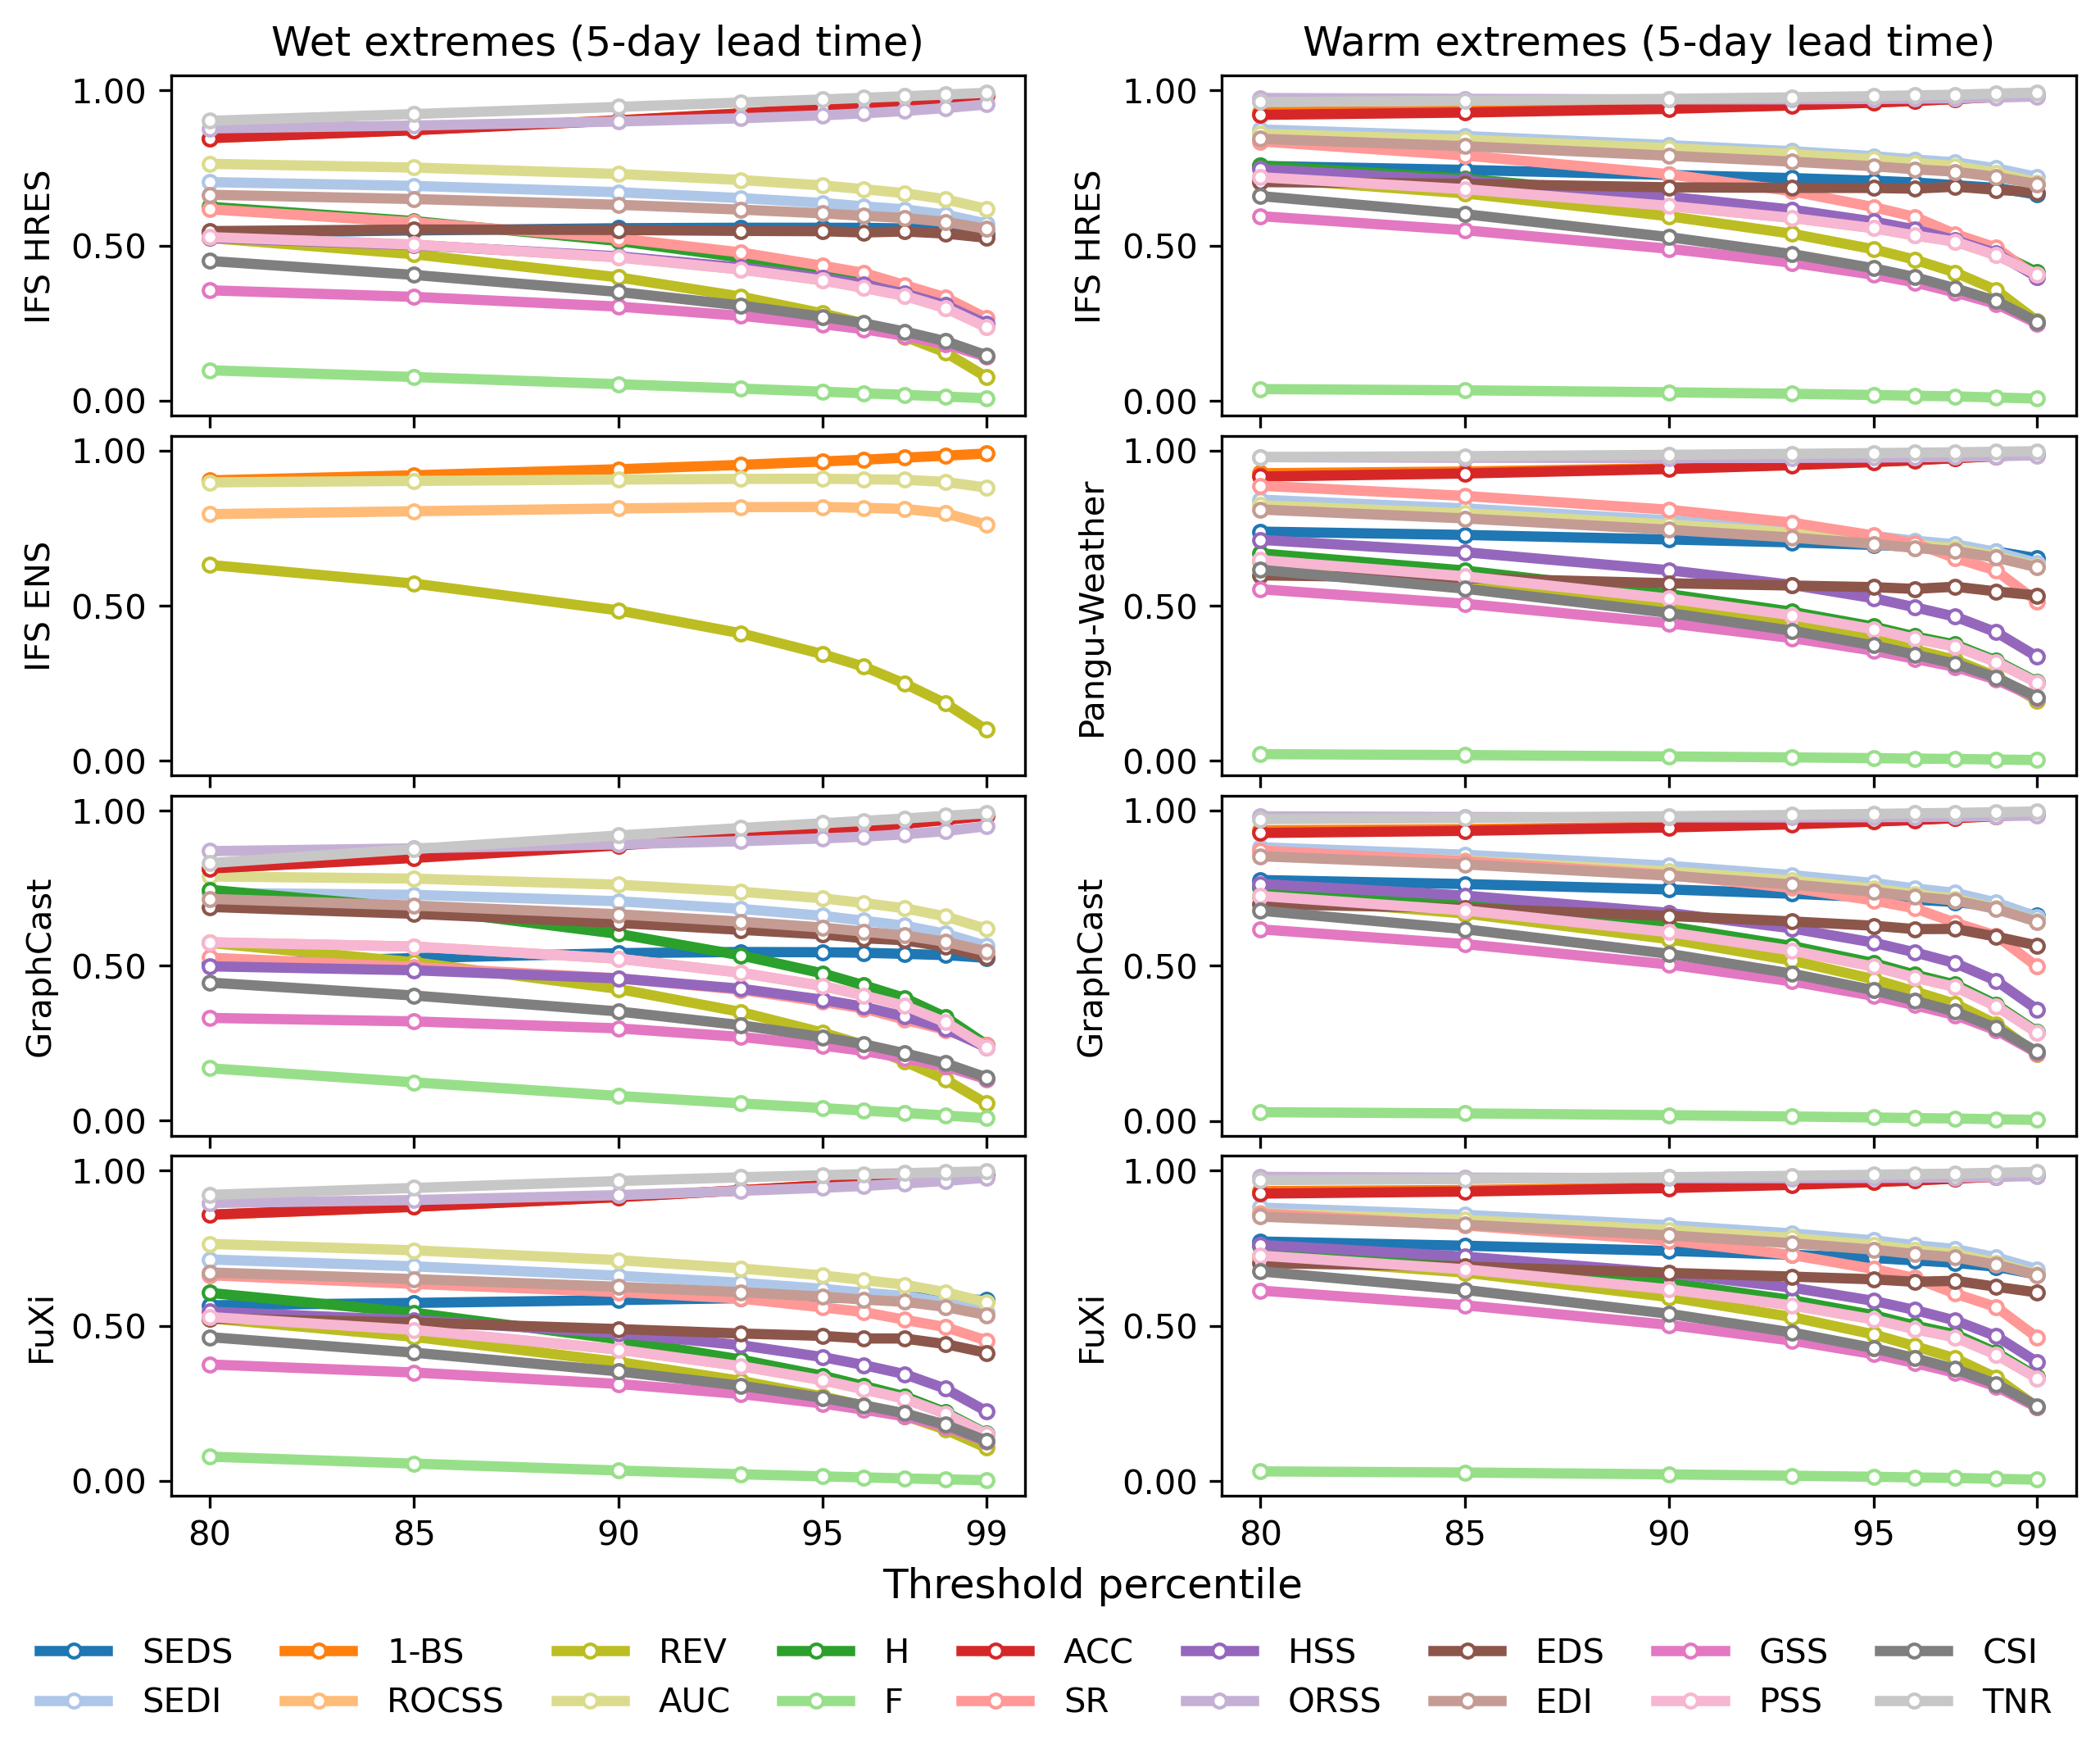

In [85]:
lead_time = 5

fig, axes = plt.subplots(4, 2, figsize=(10, 7.5), dpi=300, sharey="col",sharex="all")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.23, 
                    hspace=0.06)

for j, event in enumerate(events_categories):
    results = data[event]
    var_name = var_name_dict[event]
    models = ["hres", "pangu", "graphcast", "fuxi"] if j ==1 else ['hres', 'hres_ens', 'graphcast', 'fuxi']
    for i, model_name in enumerate(models):
    
        ax = axes[i][j]
        for k, metric_name in enumerate([
            "SEDS", "SEDI",  
            "BS","ROCSS",
            "REV", "AUC",
            "H","F",
            "ACC", "SR", 
            "HSS","ORSS",
            "EDS", "EDI",
            "GSS", "PSS",
            "CSI", "TNR",
            
            #"bias_score", "false_alarm_rate",
             
                           ]):
            if metric_name == "AUC":
                metric_quantile_data = results["ROCSS."+var_name].sel(
                    model_name=model_name)
                metric_quantile_data = (1 + metric_quantile_data)/2
            else:
                metric_quantile_data = results[metric_name+"."+var_name].sel(
                    model_name=model_name)
            if metric_name == "BS":
                metric_quantile_data = 1 - metric_quantile_data
                metric_name = "1-BS"

            # print(model_name, metric_name_dict[metric_name], metric_quantile_data.data)
            ax.plot(metric_quantile_data["quantile"]*100, metric_quantile_data,
                    lw=3, color=colors[k], #markeredgecolor= "k", 
                    marker="o", markersize=4, markerfacecolor= "white", 
                    label=metric_name)
        ax.set_xticks([80, 85, 90, 95, 99])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # ax.xaxis.set_major_formatter(FormatStrFormattertrFormatter('%.0f'))
        ax.set_title(f"{event} ({lead_time}-day lead time)") if i == 0 else 0
        ax.set_ylabel(model_full_name[model_name])

axes[3][1].legend(frameon=False, loc=(-1.4, -0.7), ncols=9,
                  handlelength=2, handletextpad=1, columnspacing=1.5)
fig.supxlabel("Threshold percentile", y=0.05)
fig.savefig(work_dir/"Figure8.jpg", dpi=300, bbox_inches="tight")